# Predicting Clutch Goalscorers in the NHL using Machine Learning Techniques

In this project, I explored various machine learning techniques to determine the best performing NHL forwards in close and tied games (often referred to as "clutch" moments). The process involved several key steps:

### 1. Identifying Correct Sources of Data
I needed to scrape data from the NHL API and Natural Stat Trick. The NHL API offers a good foundation for player bios and common goal statistics. However, Natural Stat Trick provided many advanced metrics as well as goals scored by players in close and tied games.

### 2. Data Cleaning
I merged data from the NHL API and Natural Stat Trick, then ensured the data was accurate and filtered appropriately.

### 3. Establishing a Definition of Clutch
I computed a "clutch score" for players by weighing the number of goals they scored in close and tied situations as well as in overtime.

### 4. Building a Classification Model
I attempted to classify players as "clutch" and "non-clutch" by setting thresholds for the clutch score. I used metrics such as expected goals, scoring chances, and other advanced statistics as features. The model was trained on data from the 2020-2021 to 2022-2023 NHL seasons. While the model was successful in identifying elite players and those below average, it struggled with players who fell near the classification boundaries, where small differences in their stats made it difficult to confidently label them as clutch or non-clutch.

### 5. Switching to a Regression Model
I realized that linear regression was a more feasible approach since many of the features were strongly correlated with a clutch score. It would, therefore, be easier to predict a player's clutch score rather than assigning the player an ambiguous label.  
I refined the model by using Ridge regression and performed cross-validation to ensure there was no overfitting.

### 6. Dealing with Outliers
I used Cook's Distance to identify influential points. I discovered that the model underpredicted the clutch score of elite players because their feature stats set a "ceiling" for their clutch ability. The model also overestimated some elite players who had strong underlying metrics but did not perform well in clutch games. In addition, the model struggled with below-average players who scored clutch goals at a rate that did not match their advanced stats.  
This prompted me to use a log transformation, which enabled the model to generate better predictions for elite players and significantly reduced the number of influential points. However, this transformation caused some inaccuracies for below-average players, as it amplified the difference between predicted and actual clutch scores for players with low stats.

### 7. Using the Model on a Final Test Set
After I was satisfied with the model, I used it to predict the clutch score of players based on their statistics from the start of the 2023-2024 season to the current point of the 2024-2025 season.  
In the coming weeks, I plan to deploy the model and connect it to a Power BI dashboard, which will provide real-time updates of a player's current clutch score and their predicted clutch score.


### Imports
These are the necessary imports for the project.

In [4]:
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General imports
import time
import math
import json
import requests
import functools as ft
import scipy.stats as stats

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# XGBoost and machine learning
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, PrecisionRecallDisplay, make_scorer
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA

# Hyperparameter tuning with Skopt
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Saving Model
import joblib

### NHL API
The following snippet of code scrapes data from the NHL API for the 2020-2021 to 2022-2023 NHL seasons, while accounting for any issues that may occur when connecting to the API. It also combines a player's stats across these seasons.

In [6]:
all_seasons = []

for season in range(2020, 2023):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)
print(nhl_api_df)

Successfully fetched data for season 2020-2021
Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023
      playerId    skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0      8465009       Zdeno Chara            D          127       20        0   
1      8466138      Joe Thornton            C           78       20        0   
2      8466139   Patrick Marleau            C           56        5        0   
3      8469455      Jason Spezza            C          125       33        0   
4      8469459       Mikko Koivu            C            7        1        0   
...        ...               ...          ...          ...      ...      ...   
1233   8483808   Andrei Kuzmenko            L           81       35        2   
1234   8484125     Hunter McKown            C           12        2        0   
1235   8484254      Akito Hirose            D            7        3        0   
1236   8484256  Jake Livingstone            D            5 

### Cleaning the Scraped NHL API Data
The next step is to clean the data properly:
-  Only forwards are included since defensemen score at different rates. 
-  I kept players who appeared in at least 60 games across the three seasons (approximately 20 games each season). This ensured that there was a sufficient sample size for each player.
-  Finally, some columns are renamed to maintain a consistent naming format.

In [8]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 60)]
nhl_api_df = nhl_api_df.reset_index(drop = True)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df.rename(columns={'timeOnIcePerGame': 'time_on_ice_per_game'}, inplace=True)


In [9]:
nhl_api_df['playerId']

0      8466138
1      8469455
2      8470595
3      8470604
4      8470606
        ...   
486    8482665
487    8482705
488    8482740
489    8482745
490    8483808
Name: playerId, Length: 491, dtype: int64

### Scraping Data from Natural Stat Trick
The code below establishes URL links for the pages needed from Natural Stat Trick.

In [11]:
start_season = "20202021"
end_season = "20222023"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

### Scraping Data from Natural Stat Trick
The code below scrapes data from Natural Stat Trick and stores the data for each page in a dataframe.

In [13]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

### Cleaning Data from Natural Stat Trick
After scraping the data from Natural Stat Trick, only relevant columns are included for each dataframe. These dataframes are then merged into one dataframe containing all statistics from Natural Stat Trick.

Similar to the NHL API data, only players who have played at least 60 games are included.

The dataframes do not need to be filtered for forwards because it was easier to do this through the URLs.


In [15]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rebounds Created', 'iCF']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 60]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)
merged_natural_stat.rename(columns={'Rebounds Created': 'rebounds_created'}, inplace=True)

### Standardize Player Names
Some players from Natural Stat Trick have different names compared to the NHL API. It is important to use standard names in both dataframes before merging them.


In [17]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Thomas Novak"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Tommy Novak"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [18]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rebounds_created,iCF
0,Joe Thornton,78,1,3,1,10,68,7.27,91,72,36,10,110
2,Jason Spezza,125,3,4,7,22,178,17.16,243,155,66,24,313
6,Eric Staal,125,3,2,8,19,188,21.77,253,206,106,28,328
7,Jeff Carter,209,10,11,11,49,493,51.65,618,450,236,89,781
8,Dustin Brown,113,5,5,6,26,275,30.32,364,241,122,22,445
...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,Matty Beniers,90,6,4,8,27,166,22.91,244,174,85,14,306
755,Cole Sillinger,143,3,5,6,19,241,27.17,338,276,115,36,433
758,Wyatt Johnston,82,4,4,8,24,160,18.92,207,192,94,35,281
759,Mason McTavish,89,2,6,5,19,173,22.67,231,174,92,35,285


In [19]:
nhl_api_df

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,time_on_ice_per_game
0,8466138,Joe Thornton,C,78,20,0,744.77870
1,8469455,Jason Spezza,C,125,33,0,653.25985
2,8470595,Eric Staal,C,125,23,1,868.72430
3,8470604,Jeff Carter,C,209,55,2,958.84570
4,8470606,Dustin Brown,R,113,33,0,970.80450
...,...,...,...,...,...,...,...
486,8482665,Matty Beniers,C,90,39,1,1020.96250
487,8482705,Cole Sillinger,C,143,23,0,810.29235
488,8482740,Wyatt Johnston,C,82,17,0,928.90240
489,8482745,Mason McTavish,C,89,27,0,853.62010


### Merging the Data
The dataframes containing the information from the NHL API and Natural Stat Trick are merged.

In [21]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [22]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,time_on_ice_per_game,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rebounds_created,iCF
0,8466138,Joe Thornton,C,78,20,0,744.77870,78.0,1.0,3.0,1.0,10.0,68.0,7.27,91.0,72.0,36.0,10.0,110.0
1,8469455,Jason Spezza,C,125,33,0,653.25985,125.0,3.0,4.0,7.0,22.0,178.0,17.16,243.0,155.0,66.0,24.0,313.0
2,8470595,Eric Staal,C,125,23,1,868.72430,125.0,3.0,2.0,8.0,19.0,188.0,21.77,253.0,206.0,106.0,28.0,328.0
3,8470604,Jeff Carter,C,209,55,2,958.84570,209.0,10.0,11.0,11.0,49.0,493.0,51.65,618.0,450.0,236.0,89.0,781.0
4,8470606,Dustin Brown,R,113,33,0,970.80450,113.0,5.0,5.0,6.0,26.0,275.0,30.32,364.0,241.0,122.0,22.0,445.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,8482665,Matty Beniers,C,90,39,1,1020.96250,90.0,6.0,4.0,8.0,27.0,166.0,22.91,244.0,174.0,85.0,14.0,306.0
487,8482705,Cole Sillinger,C,143,23,0,810.29235,143.0,3.0,5.0,6.0,19.0,241.0,27.17,338.0,276.0,115.0,36.0,433.0
488,8482740,Wyatt Johnston,C,82,17,0,928.90240,82.0,4.0,4.0,8.0,24.0,160.0,18.92,207.0,192.0,94.0,35.0,281.0
489,8482745,Mason McTavish,C,89,27,0,853.62010,89.0,2.0,6.0,5.0,19.0,173.0,22.67,231.0,174.0,92.0,35.0,285.0


### Null values
Check that there are no Null values after merging.

In [24]:
null_rows = merged_clutch_goals[merged_clutch_goals.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
     playerId            Player positionCode  gamesPlayed  assists  ot_goals  \
191   8477073  Kurtis MacDermid            L          130       10         0   

     time_on_ice_per_game  GP  goals_up_by_one  goals_down_by_one  \
191              581.7219 NaN              NaN                NaN   

     goals_when_tied  total_goals  shots  ixG  iFF  iSCF  iHDCF  \
191              NaN          NaN    NaN  NaN  NaN   NaN    NaN   

     rebounds_created  iCF  
191               NaN  NaN  


Since Kurtis MacDermid played defense and forward, I excluded him from the dataset.

In [26]:
merged_clutch_goals.drop(191, inplace = True)

In [27]:
merged_clutch_goals.drop(376, inplace = True)

In [28]:
null_rows = merged_clutch_goals[merged_clutch_goals.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, assists, ot_goals, time_on_ice_per_game, GP, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, rebounds_created, iCF]
Index: []


### Changing Columns
Drop the "GP" column since it existed in both previously merged dataframes.

Compute per game stats to accurately compare players.

In [30]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)
columns = ['ot_goals', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'rebounds_created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


### Clutch Score
After cleaning the data, we can now compute a weighted clutch score for each player.
- Goals scored when tied and down by one are given the most weighting since these are the most representative of high-pressure situations.
- Goals scored when up by one are still close situations but may not be as "clutch" compared to goals scored when tied and down by one.
- OT goals are also given a smaller weight, since they occur infrequently compared to other goals. They are also only scored during 3v3 play, which differs from the rtiaio55nal v5.


In [32]:
merged_clutch_goals['clutch_score'] = (
    0.35 * merged_clutch_goals['goals_when_tied_per_game'] + 
    0.35 * merged_clutch_goals['goals_down_by_one_per_game'] + 
    0.10 * merged_clutch_goals['goals_up_by_one_per_game'] + 
    0.20 * merged_clutch_goals['ot_goals_per_game']
)

### Rankings Players Based on their Clutch Score
All scores are multiplied by 100 to make them more interpretable.
The scores are then ranked and the top 20 players are shown below.

In [34]:
merged_clutch_goals['clutch_score'] *= 100
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
335,Auston Matthews,14.45,1.0
254,David Pastrnak,13.14,2.0
284,Connor McDavid,12.80,3.0
321,Kirill Kaprizov,12.44,4.0
240,Leon Draisaitl,12.27,5.0
54,Max Pacioretty,11.25,6.0
400,Jason Robertson,10.92,7.0
340,Alex DeBrincat,10.49,8.0
220,Aleksander Barkov,10.41,9.0
242,William Nylander,10.40,10.0


### Distribution of Clutch Scores
As shown by the histogram below, the data for clutch scores is right skewed. Most players have a below average clutch score and there are a small number of elite players


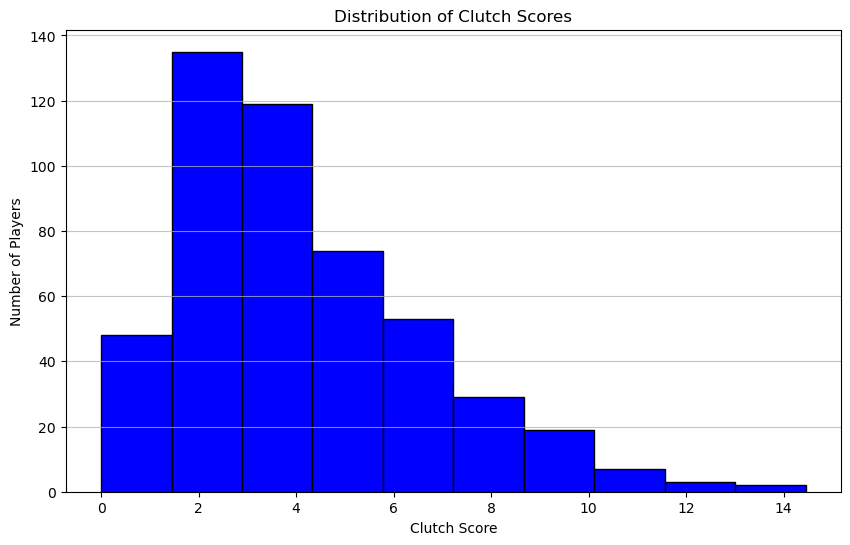

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Clutch Score")
plt.ylabel("Number of Players")
plt.title("Distribution of Clutch Scores")
plt.show()

### Threshold for Clutch Scores
It makes sense to label "clutch" goalscorers as a higher percentile of data. Thus, all players who had a clutch score in the 85th percentile were in the positive class.
This approach already highlights the potential shortcomings of classification for this project. Is a player in the 80 to 84th percentile suddenly not "clutch"? Even if we used a multiclass classification approach, how can we distinguish between players who fall near the boundaries?

In [38]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)

def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

### Class Imbalance
Due to the right skew distribution of the data, there are very few goalscorers classified as "clutch".

In [40]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    415
1     74
Name: count, dtype: int64

### Setting up a Classification Model

My initial approach was to select various classification models (e.g. XGBoost, random forest, KNN) and compare them with the Friedman statistical test. I started working on an XGBoost model, but then realized that a classification approach was not idlea.


### Starting with XGBoost

XGBoost builds an ensemble of decision trees by correcting the prediction errors of previous trees.

Many statistics relevant to a player's goalscoring (e.g. shooting, assists, ice time) are used as features. The model is then trained on an 80-20 split of the data. The **stratify = y** parameter ensures that the training and testing sets have the same class distribution as the original dataset (i.e. same representation of the number of clutch and non-clutch goalscorers). Therefore, the minority class (clutch goalscorers) will not be underrepresented.

The model uses the log loss evaluation metric, which measures the difference between the true class labels (0 or 1) and the predicted probabilities fir the positive class. A greater difference between the predicted probabilities and the actual labels results in a higher log loss. 

A full glossary of the features can be found on the __[Natural Stat Trick website.](https://www.naturalstattrick.com/glossary.php?players)__


In [43]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'rebounds_created_per_game','time_on_ice_per_game']
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Initial Evaluation of the Model

The XGBoost model is evaluated using StratifiedKFold cross-validation with 10 splits. Four metrics are used to assess the model's performance: accuracy, precision, recall, and F1 score.

With 10-fold cross-validation, the dataset is divided into 10 groups. We train the model on 10 - 1 = 9 groups and test the model (evaluate its metrics) on the remaining group. This process is repeated 10 times to ensure every group serves as a test set. The metrics are then average across the 10 folds.

As with stratify = y, each fold has the same class distribution as the original dataset (i.e. same representation of the number of clutch and non-clutch goalscorers).

### Definitions of Metrics

Accuracy: The proportion of correct predictions among the total number of predictions.

Precision: The proportion of true positives among all instances predicted as positive. It answers the question: "When we predicted positive (a player classified as clutch), how many times were we correct?"

Recall: The proportion of true positives among all actual positives. It answers the question: "Of all the actual positives (clutch goalscorers), how many did the model correctly identify?"

F1 Score: The harmonic mean of precision and recall. Taking the harmonic mean ensures the F1 Score is not skewed by extreme values of precision and recall.

### Inflated Accuracy

The model's accuracy appears to be quite high (approximately 90%), but this is most likely due to the high class imbalance. The model can predict the majority class most of the time, without effectively learning to identify the minority class.

The model seems to have a high precision and low recall. It is very cautious about predicting the minority class (clutch goalscorers), which results in fewer false positives. So when the model predicits positive, it is mostly correct. However, this means that the model misses many clutch goalscorers and has a low recall. 

The F1 score is pulled down by the low recall to highlight the model's issues with rarely predicting the positive class and missing clutch goalscorers.

In [47]:
skf = StratifiedKFold(n_splits=10)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

fit_time          0.238109
score_time        0.029206
test_accuracy     0.887628
test_precision    0.839545
test_recall       0.603571
test_f1           0.635051
dtype: float64

### Learning Curves
The learning curves plot the log loss of the training against the log loss for cross-validation. The very low log loss for training indicates that the model has nearly 100% accuracy in predicting clutch players from the training data. However, the log loss increases to 0.4 on the cross-validation data. Due to the high negative class imbalance, the model can just predict non-clutch most of the time. When it predicts the positive class, it may not be confident enough which shows the model has memorized the patterns in the training data and cannot generalize to new data during cros- validation
Note: The high imbalance in the dataset means that stratified cross-validation may not be able to create balanced splits, leading to the error message.


C:\Users\Work\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Work\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Work\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\Work\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of 

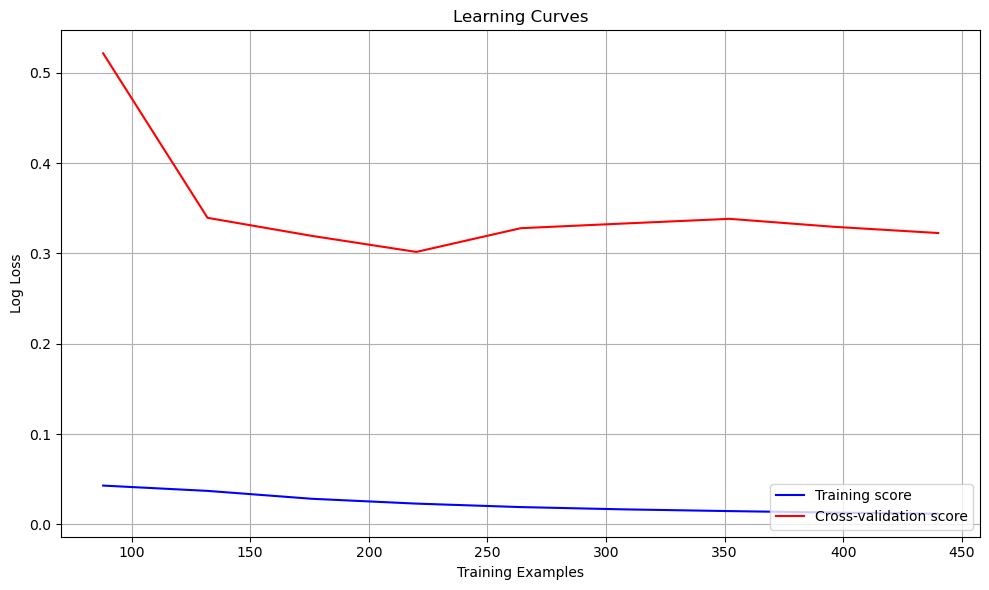

In [49]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss'
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Feature importance
Feature importance helps us to determine which features the model relies on during training and remove less influential features. This enables the model to focus on the most relevant information when training and improve its ability to generalize to unseen data.

The F score (Feature Importance score) reflects how frequently a feature contributes to the decision-making process in the model. For gradient boosting models, importance is based on the improvement in the loss function when a feature is used to split the data within the trees.


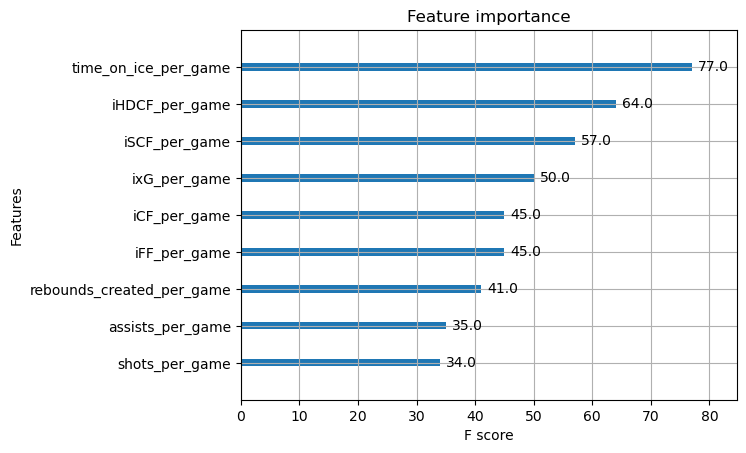

In [51]:
plot_importance(xgb_model)
plt.show()

### Obtaining the Most Important Features
The following lines of code obtain all features with an F score greater than 40.

In [53]:
importance = xgb_model.get_booster().get_score(importance_type='weight')
important_features = {}

for feature, score in importance.items():
    if score >= 40:
        important_features[feature] = score

important_feature_names = list(important_features.keys())

X_adjusted = merged_clutch_goals[important_feature_names]  


### Hyperparameter tuning
Hyperparameter tuning involves adjusting parameters to improve the model's metrics and reduce overfitting. These parameters are set before training since the model cannot learn them from the data. Below are hyperparameters that are tuned for the XGBoost model:

- **max_depth:** This controls the maximum depths of the trees. Although a greater depth allows the model to capture more intricate patterns in the data, it can start memorizing patterns in the data and overfit.

- **min_child_weight:** As each node is split based on a condition, data is passed down to nodes. min_child_weight is the minimum number of samples that a node must hold before it is split further. If there are less than min_child_weight samples at that node, the node will not be split further. This means that the node becomes a leaf.

    A higher min_child_weight means that a split will only occur if there is enough data and the model will not overfit to small non-representative samples of the data.

- **n_estimators:** n_estimators represents the number of trees that the model will use during training. As with depth, a higher number of trees can help the model identify more complex patterns in the data. However, the model can become too complex and may start memorizing the data. This will lead to overfitting.

- **learning_rate:** learning_rate controls how much each tree's contribution is scaled during training.
  
    A lower learning rate means that each tree's contribution is smaller, and the model will make smaller adjustments after adding a new tree. This can help the model generalize the data, but may also require more trees, thus leading to overfitting.

    A higher learning rate means each tree's contribution is larger and the model will make larger adjustments after adding a new tree. This can lead to a faster solution but cause the model to miss important details in the data and overfit.

- **reg_alpha:** This parameter helps to reduce the number of features considered in splits. If a feature has no or little contribution in splits, reg_alpha pushes its weight to 0. This enables the model to focus on important features and leads to better generalization.

- **reg_lamda:** reg_lamda adds a penalty to the squared values of the feature weights that are have no or little contribution in splits. This discourages large weights but does not force weights to zero, unlike reg_alpha. This leads to better generalization without necessarily eliminating features.

- **subsample:** subsample controls the fraction of data that is randomly sampled for training in each tree. By limiting the amount of training data, subsample prevents the model from memorizing details in the data and leads to less overfitting.

- **colsample_bytree :** This parameter controls the fraction of features that are randomly sampled for each tree. Since colsample_bytree limits the number of features used in each tree, it prevent the model from becoming overly dependent on any single feature and leads to better generalization.


In [55]:
from scipy.stats import randint, uniform

param_grid = {
    'max_depth': randint(2, 6),
    'min_child_weight': randint(2, 4),
    'n_estimators': randint(200, 301), 
    'learning_rate': uniform(0.03, 0.01),
    'reg_alpha': uniform(0.75, 0.6), 
    'reg_lambda': uniform(0.75, 0.6), 
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3) 
}


### Random Search
Random search is a hyperparameter tuning technique that randomly samples hyperparameter combinations from the parameter grid. The model is then trained and evaluated using k-Fold cross-validation on k - 1 subsets of the training data. The cross-validation score (in this case, F1 score) is calculated for the test fold, and the average score across all k iterations is used to evaluate the performance of that particular set of hyperparameters. This method helps to find a good set of hyperparameters without exhaustively testing every possible combination, unlike grid search.

I have repeated random search multiple times on different train and test splits to obtain a good representation of the model's performance. After each train and test split, the model's class weights are adjusted.


### Results of Hyperparameter Tuning

From the learning curves, it seems that hyperparameter tuning has helped to reduce overfitting.

With regards to the model's performance metrics, it is simply not enough to look at the recall and precision score. We must understand where the model is misclassifying clutch players.

After each randomly selected train test split, I printed out the model's classification results. It appears that the model can correctly classify higher ranked players but struggles with players close to the boundary points (ranks between 45 and 74). The model also incorrectly classifies players with varying performance over the three seasons. 

This makes sense because we are essentially assigning an ambiguous label to a clutch player. Is a player 0n the 84th to 83rd percentile suddenly not clutch? Classification may also have difficulties detecting trends in player performance.


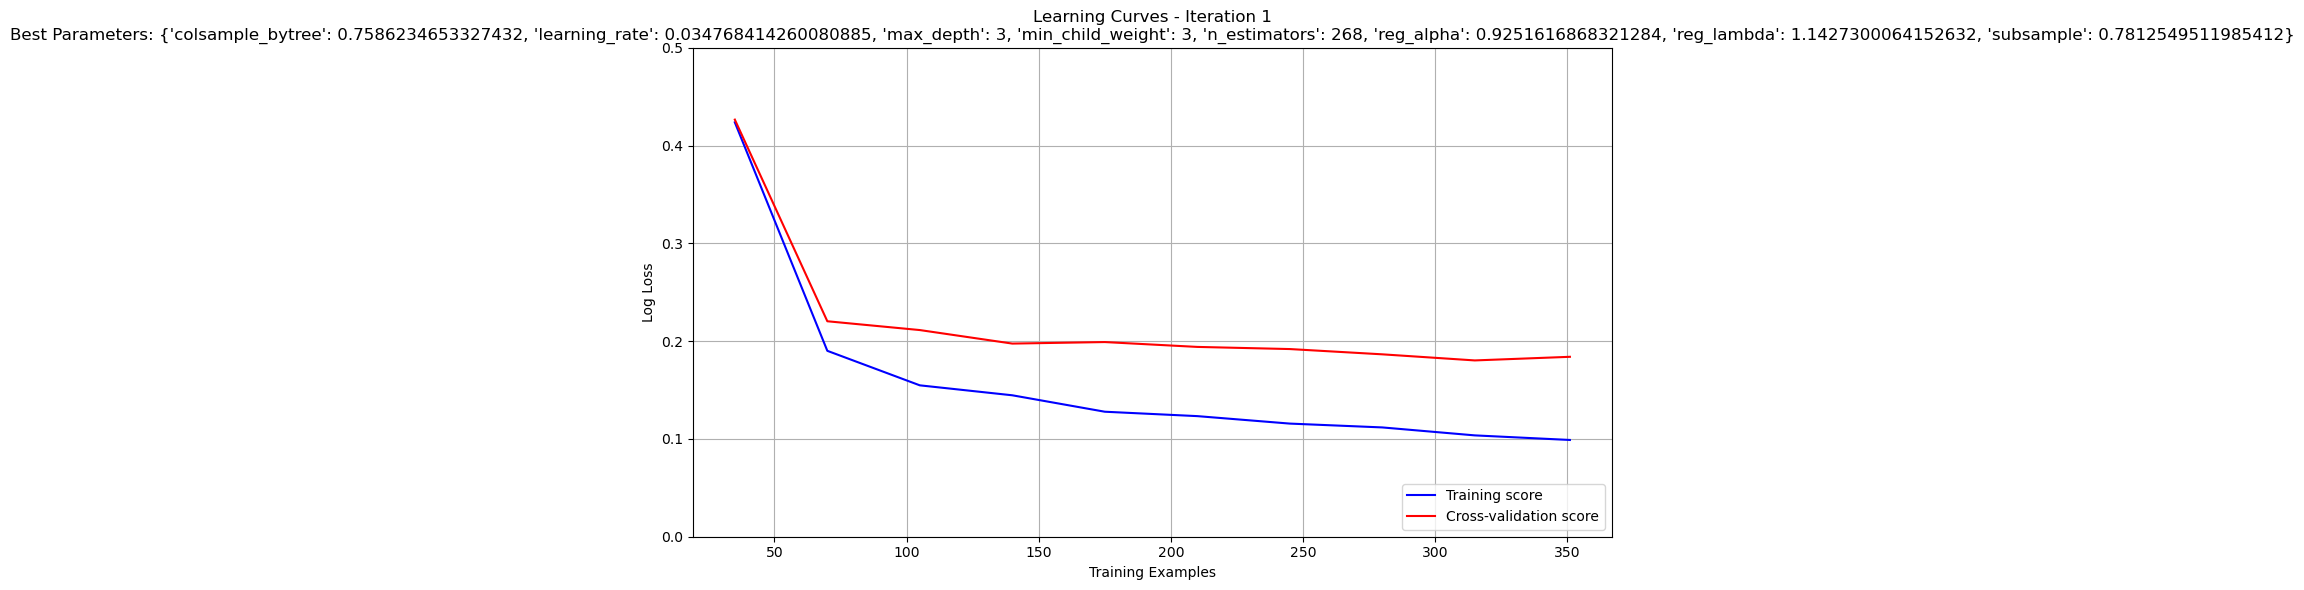


Precision Score:  0.7333333333333333
Recall Score:  0.7333333333333333

Correct Classfications
              Player  clutch_score_rank  Actual  Predicted
240   Leon Draisaitl                5.0       1          1
335  Auston Matthews                1.0       1          1
255     Adrian Kempe               37.0       1          1
130  Johnny Gaudreau               40.0       1          1
300      Roope Hintz               20.0       1          1
27     Brad Marchand               44.0       1          1
355     Jordan Kyrou               67.0       1          1
201    Jake Guentzel               30.0       1          1
54    Max Pacioretty                6.0       1          1
82      Evander Kane               26.0       1          1
222   Elias Lindholm               56.0       1          1

Missed Cltuch Players
               Player  clutch_score_rank  Actual  Predicted
310      Jake DeBrusk               69.0       1          0
50       David Perron               72.0       1     

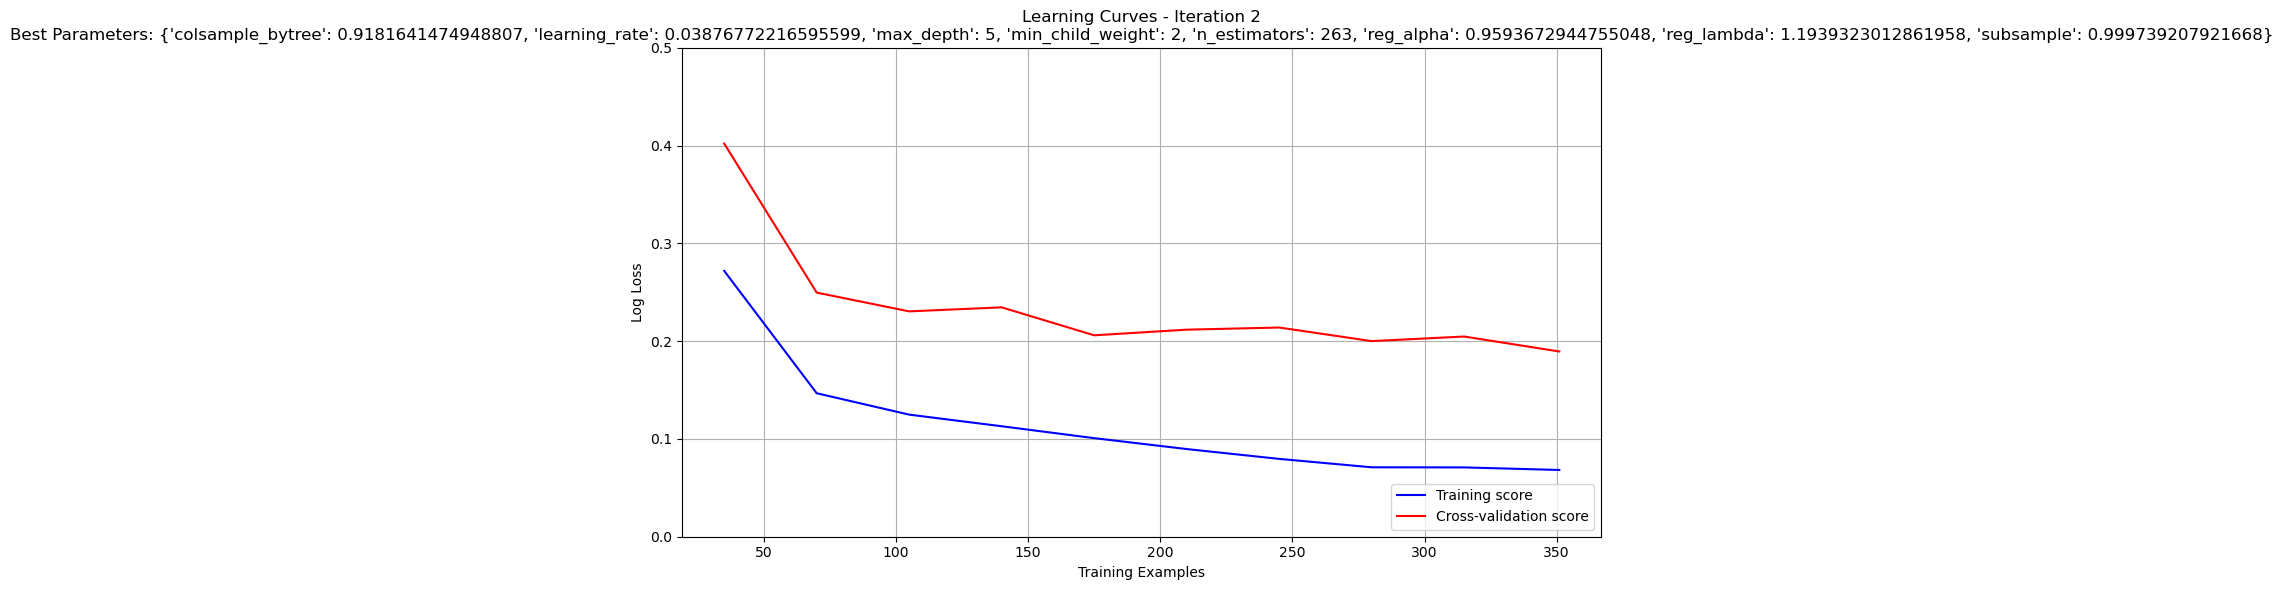


Precision Score:  0.7333333333333333
Recall Score:  0.7333333333333333

Correct Classfications
                Player  clutch_score_rank  Actual  Predicted
255       Adrian Kempe               37.0       1          1
285        Jack Eichel               54.0       1          1
60      Steven Stamkos               16.0       1          1
222     Elias Lindholm               56.0       1          1
358  Pierre-Luc Dubois               61.0       1          1
220  Aleksander Barkov                9.0       1          1
247       Dylan Larkin               35.0       1          1
333    Matthew Tkachuk               57.0       1          1
355       Jordan Kyrou               67.0       1          1
14       Alex Ovechkin               14.0       1          1
239       Sam Reinhart               50.0       1          1

Missed Cltuch Players
              Player  clutch_score_rank  Actual  Predicted
86     Chris Kreider               25.0       1          0
490  Andrei Kuzmenko           

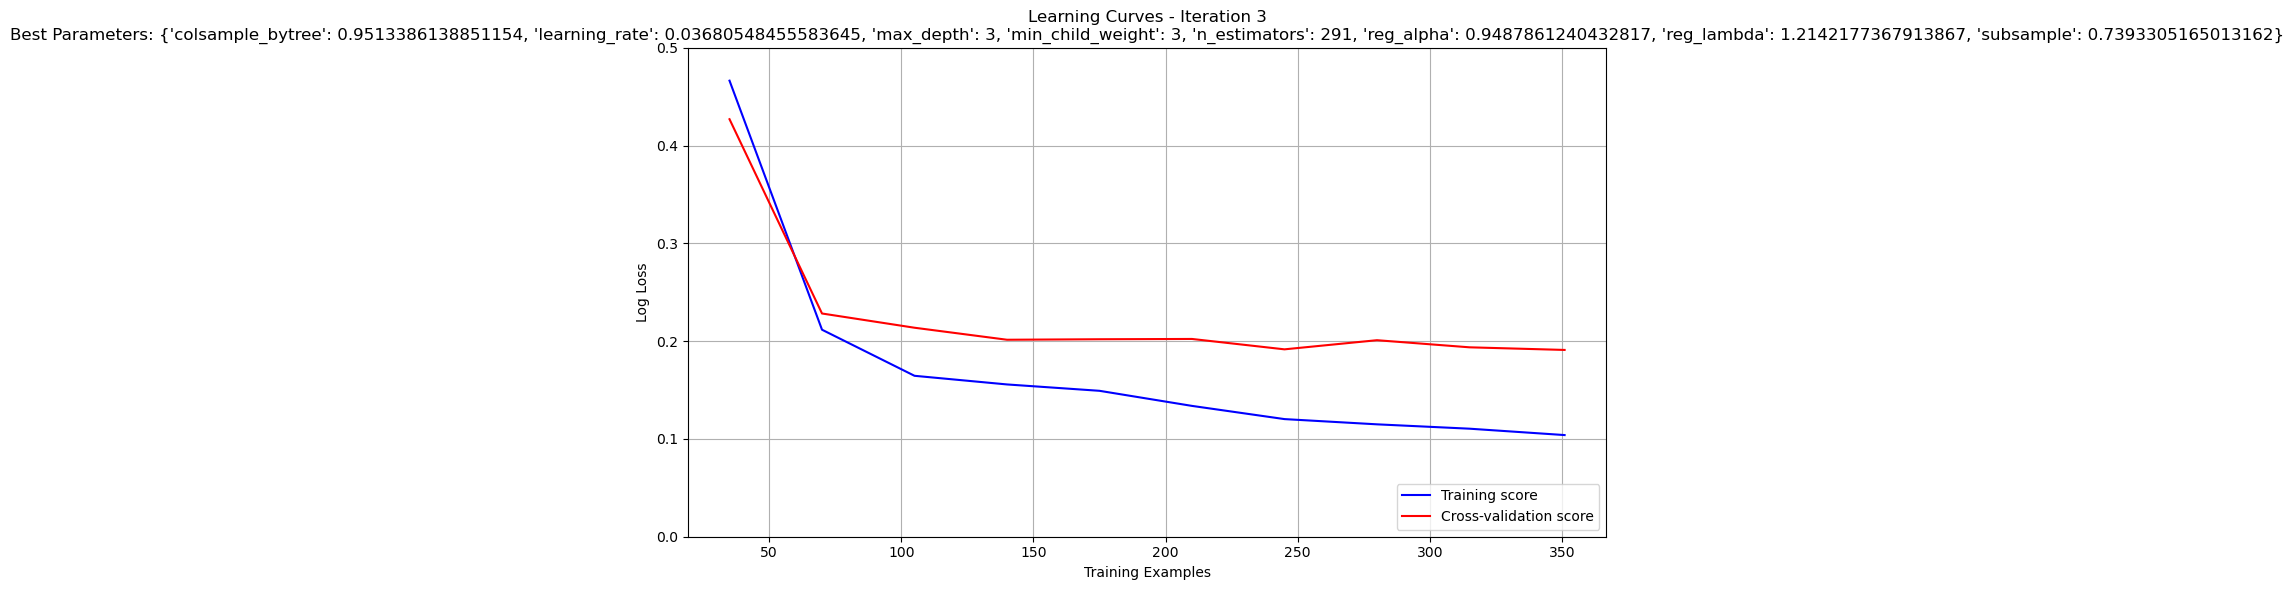


Precision Score:  0.6875
Recall Score:  0.7333333333333333

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
342    Clayton Keller               48.0       1          1
113        Zach Hyman               51.0       1          1
224         Bo Horvat               32.0       1          1
362     Tage Thompson               11.0       1          1
138      Boone Jenner               60.0       1          1
315    Artemi Panarin               74.0       1          1
291     Sebastian Aho               18.0       1          1
20      Sidney Crosby               34.0       1          1
80       John Tavares               53.0       1          1
10   Patrice Bergeron               55.0       1          1
255      Adrian Kempe               37.0       1          1

Missed Cltuch Players
            Player  clutch_score_rank  Actual  Predicted
81    Matt Duchene               49.0       1          0
100  Tyler Toffoli               58.0       1          0
40

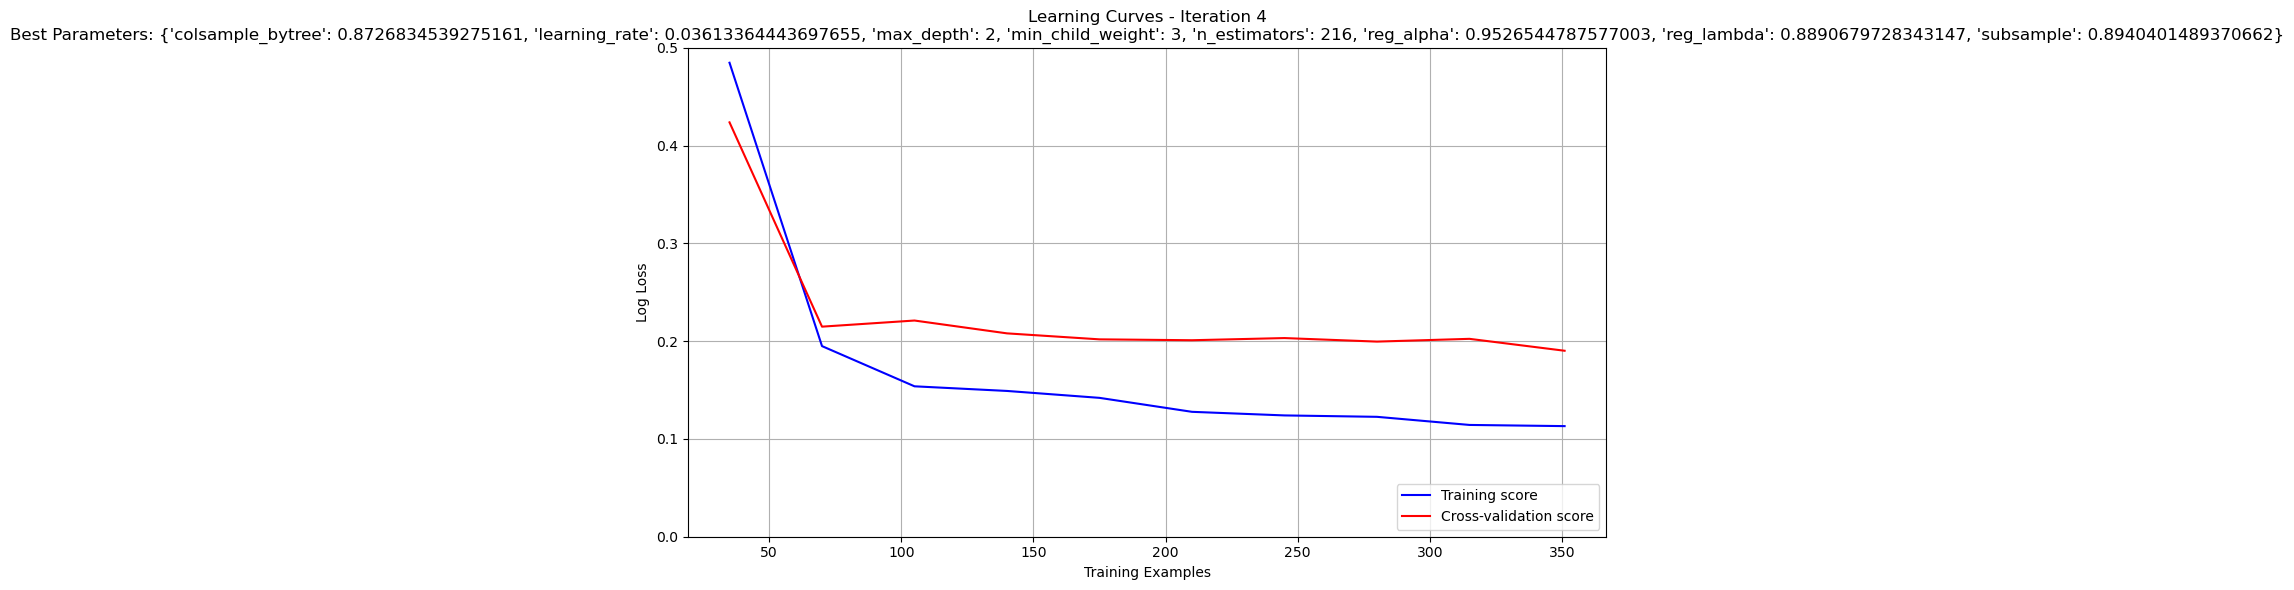


Precision Score:  0.7058823529411765
Recall Score:  0.8

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
82       Evander Kane               26.0       1          1
10   Patrice Bergeron               55.0       1          1
204  Carter Verhaeghe               59.0       1          1
113        Zach Hyman               51.0       1          1
60     Steven Stamkos               16.0       1          1
387     Nico Hischier               47.0       1          1
149    Mika Zibanejad               27.0       1          1
224         Bo Horvat               32.0       1          1
14      Alex Ovechkin               14.0       1          1
219  Nathan MacKinnon               17.0       1          1
222    Elias Lindholm               56.0       1          1
459       Jack Hughes               21.0       1          1

Missed Cltuch Players
           Player  clutch_score_rank  Actual  Predicted
22     T.J. Oshie               66.0       1          0
341 

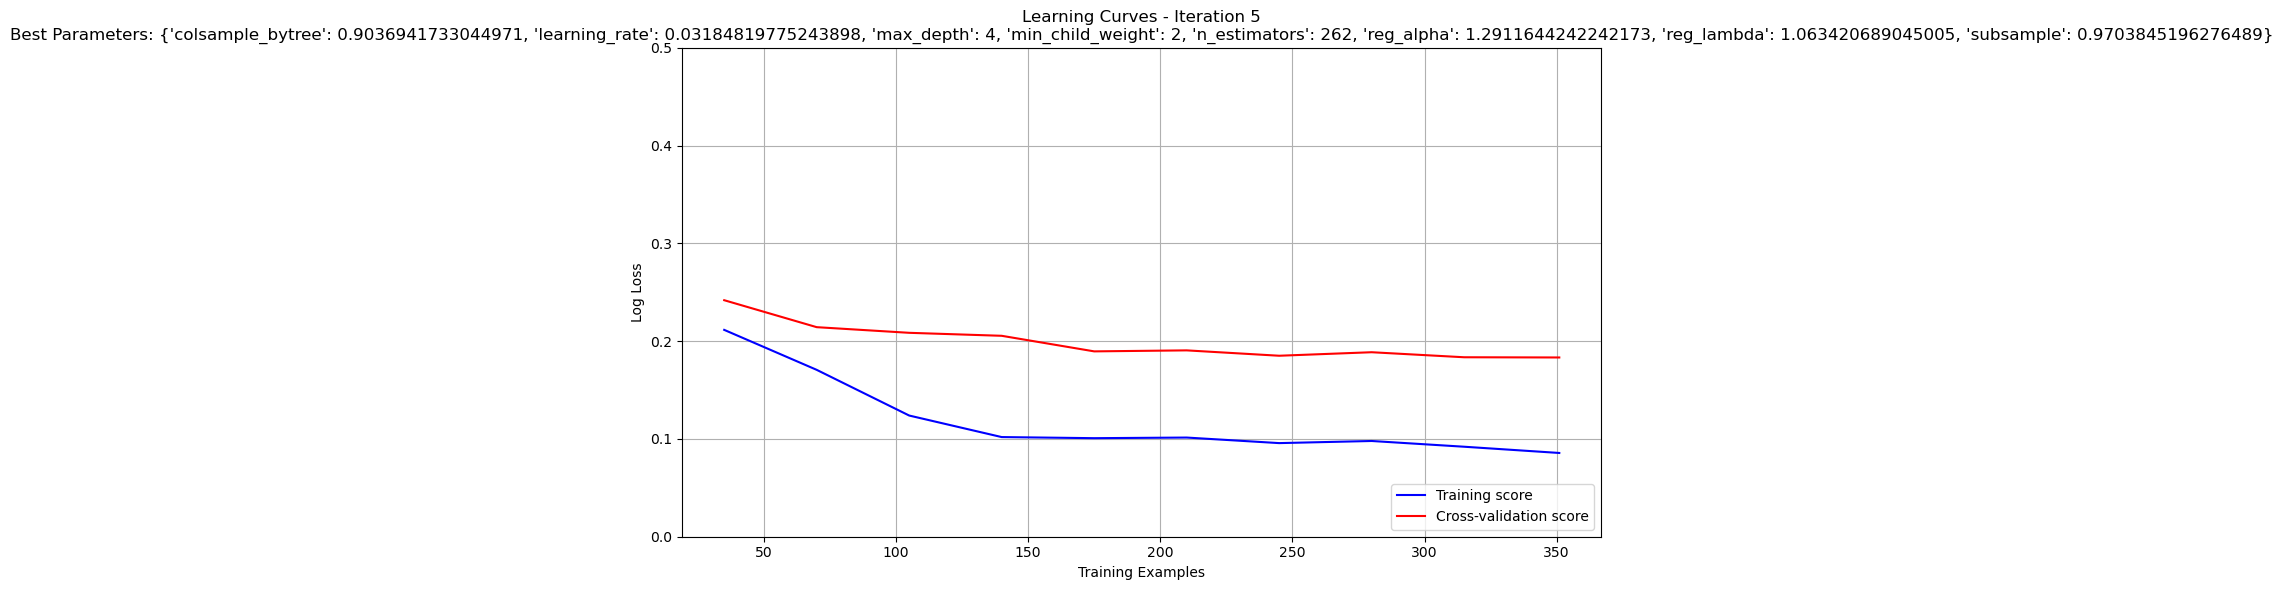


Precision Score:  0.75
Recall Score:  0.8

Correct Classfications
              Player  clutch_score_rank  Actual  Predicted
130  Johnny Gaudreau               40.0       1          1
245      Kevin Fiala               71.0       1          1
82      Evander Kane               26.0       1          1
342   Clayton Keller               48.0       1          1
149   Mika Zibanejad               27.0       1          1
288   Mikko Rantanen               13.0       1          1
113       Zach Hyman               51.0       1          1
459      Jack Hughes               21.0       1          1
315   Artemi Panarin               74.0       1          1
60    Steven Stamkos               16.0       1          1
86     Chris Kreider               25.0       1          1
239     Sam Reinhart               50.0       1          1

Missed Cltuch Players
               Player  clutch_score_rank  Actual  Predicted
341      Patrik Laine               42.0       1          0
204  Carter Verhaeghe  

In [67]:
from sklearn.model_selection import RandomizedSearchCV

cv = StratifiedKFold(n_splits=10)

precision_list = []
recall_list = []
f1_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Log Loss')
    plt.ylim(0, 0.5)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(5):
    rs = np.random.randint(1, 1000)

    train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state = rs
    )

    class_weights = compute_sample_weight(class_weight='balanced', y=train_y)
    
    xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss')
    xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

    random_search = RandomizedSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, n_jobs = -1, scoring = 'f1')

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  

    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)

    print("")
    print("Precision Score: ", precision)
    print("Recall Score: ", recall)
    print("")

    
    results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[test_y.index, 'Player'],
    'clutch_score_rank': merged_clutch_goals.loc[test_y.index, 'clutch_score_rank'],
    'Actual': test_y,
    'Predicted': y_pred,
    })

    print("Correct Classfications")
    print(results.loc[(results['Actual'] == 1) & (results['Predicted'] == 1)])

    print("")

    print("Missed Cltuch Players")
    print(results.loc[(results['Actual'] == 1) & (results['Predicted'] == 0)])

    print("")

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

### Switching to Regression

Although the classification model does show advantages in correctly classifying some player, I believe that regression is more suitable:

1. Unlike Classification, regression can be used to predict the player's clutch score (a continuous label), rather than assigning them to classes that may not clearly define a "clutch player". This makes the model easier to interpret and leads to more accurate predictions.
2. Regression can account for the trends in player performance and provide better predictions.


### Features
The same features from classification are used. These features show a strong positive correlation with clutch score, which indicates that a linear regression model is suitable


In [70]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game']
X= merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

correlation = X.corrwith(y) 
print(correlation)

shots_per_game               0.876858
ixG_per_game                 0.873543
iFF_per_game                 0.880238
iSCF_per_game                0.887516
iHDCF_per_game               0.716309
assists_per_game             0.761495
iCF_per_game                 0.875150
rebounds_created_per_game    0.763970
time_on_ice_per_game         0.787757
dtype: float64


### Scatter Plots
The scatter plots further show the strong positive correlation of the features with clutch score.

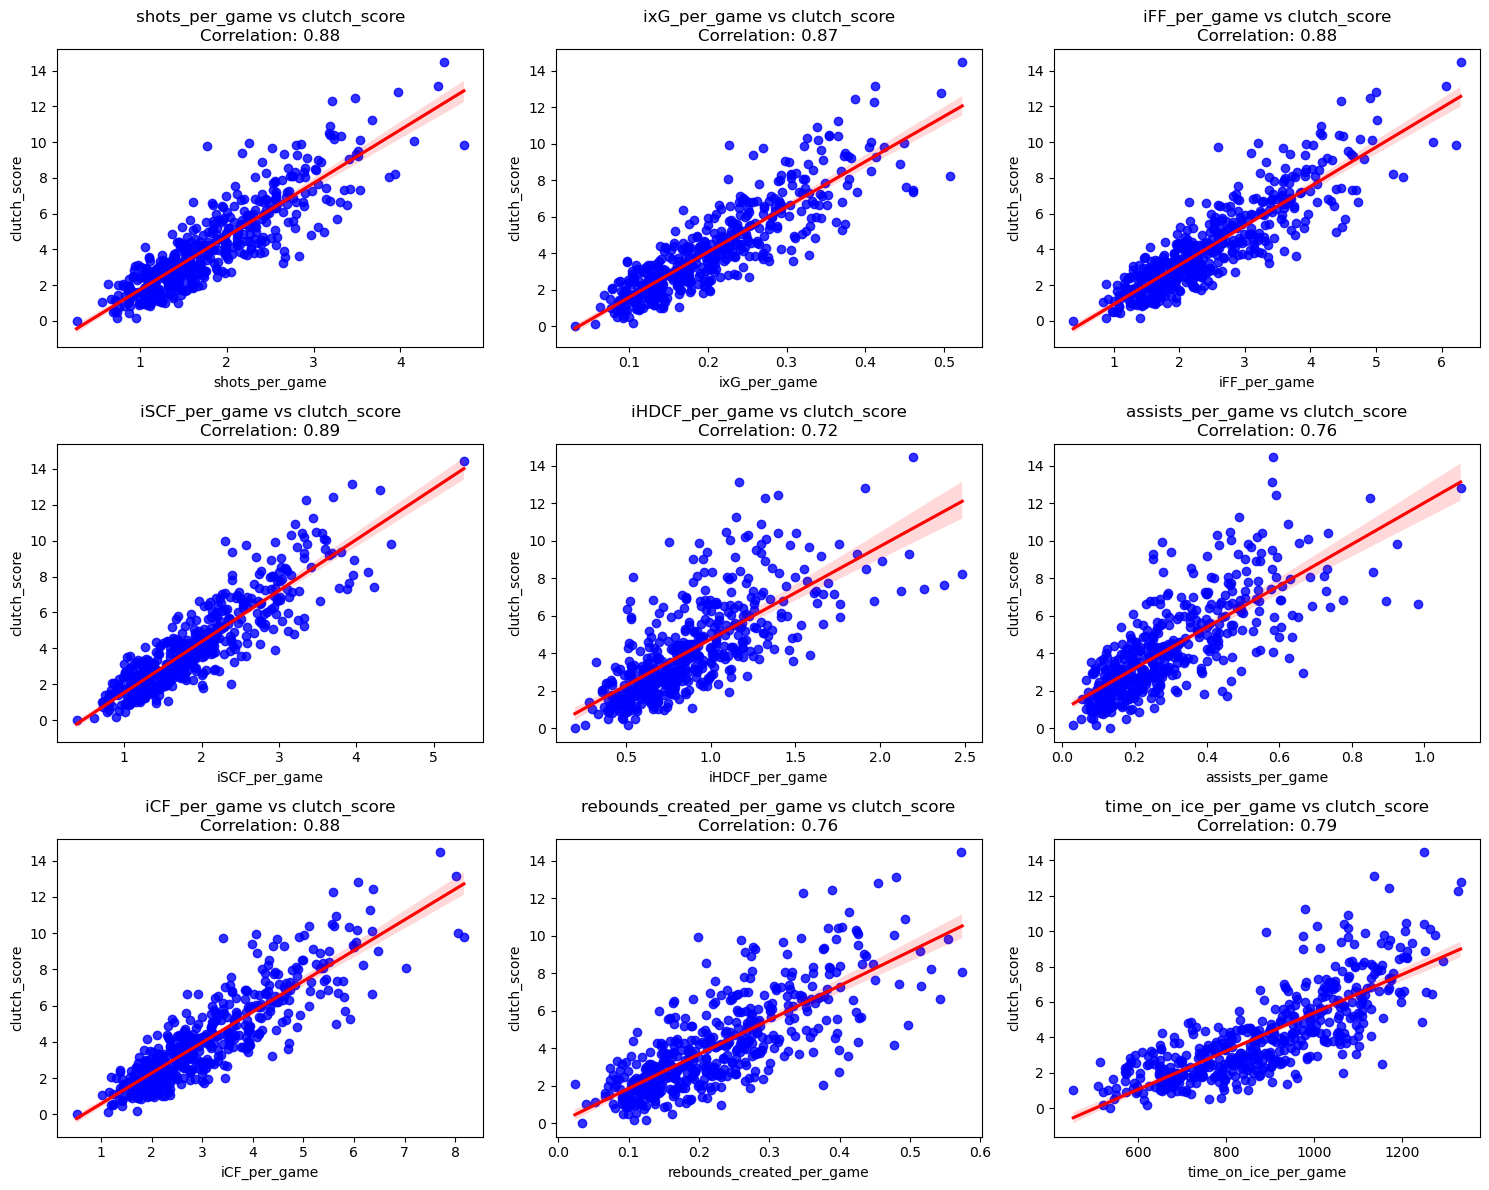

In [72]:
plt.figure(figsize=(15, 12))  

for i, var in enumerate(x_var):
    plt.subplot(3, 3, i+1)
    
    sns.regplot(data=merged_clutch_goals, x=var, y=y, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    
    plt.title(f'{var} vs {y_var}\nCorrelation: {correlation[var]:.2f}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel(y_var)

plt.tight_layout()  
plt.show()

### Multicollinearity
Even though the features are highly correlated with each other, we should not expect any change in predictive performance because the correlations will exist in the test and training set. The model can still use the correlated features to make accurate predictions because the feature patterns learned during training will apply similarly in the test set.

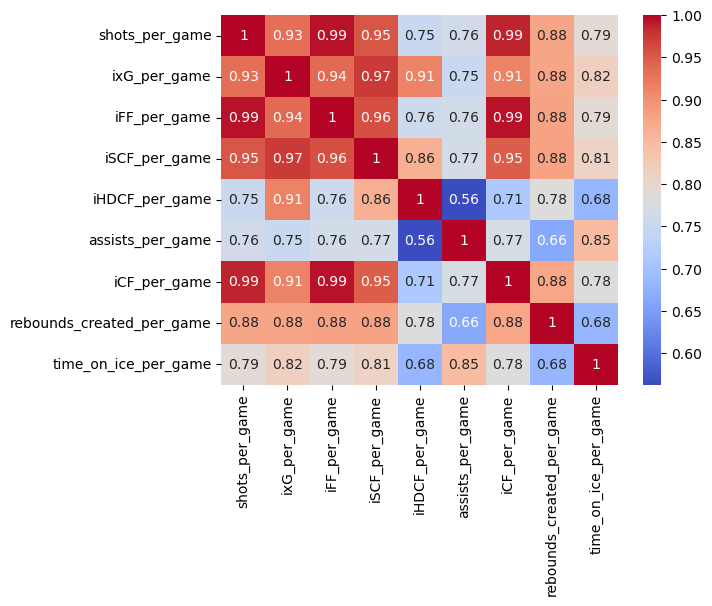

In [74]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

### Ridge Regression
Ridge Regression is a variant of linear regression that applies a penalty to the squared values of the coefficients in the regression equation. The penalty is controlled by the alpha parameter, which determines the strength of regularization. A higher value of alpha applies a stronger penalty which decreases the coefficients more. Unlike Lasso Regression, Ridge Regression does not set coefficients to zero and eliminate features. It instead keeps all features in the model but reduces the influence of less important features by shrinking their coefficients

Decreasing coefficients reduces the complexity of the model since the model will not become heavily reliant on certain features. It can instead focus on relevant features and generalize to unseen data.

We also must scale the data by setting the mean of each feature to 0 and standard deviation to 0, so that not one single feature dominates the model.
.


### Metrics
- MSE (Mean Squared Error): MSE measures the average squared difference between the predicted values and the actual values. Lower values indicate better model performance. It penalizes large errors more because the differences are squared.

- RMSE (Root Mean Squared Error): RMSE is the square root of MSE. It provides errors in the same units as the original data, making it easier to interpret. Like MSE, lower values are better, and it emphasizes larger errors due to squaring.

- Median  Error: Median of the absolute differences between predicted and actual values and is not skewed by large errors, unlike MSE and RMSE.
    
- R²: R² represents the proportion of the variance in the dependent variable (y) that is explained by the independent variable(s) (x) in the model. In other words, it shows how well the changes in x can explain or predict the changes in y. Values closer to 1 indicate that the model explains most of the variability in y, meaning a better fit, while values closer to 0 suggest that the model explains little of the variability in y, meaning a poorer fit. However, R^2 can be inflated by overfitting. As more predictors are features to the data, R^2 increases because the model can explain more variance in y, even if the features are not important.

- Adjusted R²: Adjusted R² adjusts R² for the number of predictors in the model. It accounts for overfitting by penalizing excessive use of unhelpful features. Like R², higher values are better.


In [77]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals[y_var]

X_scaled = StandardScaler().fit_transform(X_adjusted)

train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

alphas_random = np.random.uniform(0.0001, 1000, 50)

ridge_cv = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv.fit(train_x, train_y)

y_pred = ridge_cv.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
median_error = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("Median Error: ", median_error)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))

MSE:  1.380410621868117
RMSE:  1.174908771721497
Median Error:  0.6928510618110326
R²:  0.8170361248327684
Adjusted R²:  0.8127141435296055


### Learning Curves
It is important to evaluate the learning curves for ridge regression to determine if there is overfitting in the model. 

Although many of scikit-learn’s metrics are regarded as better when they return higher values, MSE is a loss function. Therefore, we take the negative value of MSE for the learning curve since higher positive values of MSE will yield more negative values.

### Interpreting the Graph


The MSE is multiplied by one, so the learning curve graph shows positive MSE and is easier to interpret (as smaller values of MSE are better).

The learning curves do not show significant overfitting. After approximately 250 samples, both training and validation curves converge to an MSE of less than 
2.
Thus, Ridge Regression is the correct choice for generalizing the training data.


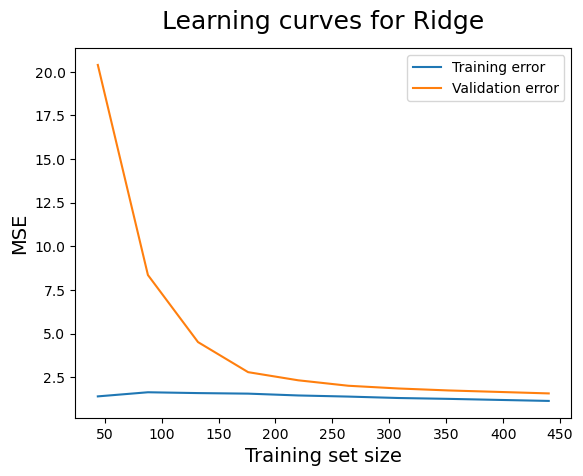

In [80]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, validation_scores = learning_curve(
ridge_cv,
X_scaled,
y, train_sizes = train_sizes, cv = 10,
scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Ridge', fontsize = 18, y = 1.03)
plt.legend()

### Analyzing the Residuals
It is important to not just look at MSE and MAE, but also where the model is having issues with predicting the clutch scores of players.

From the dataframe below, it appears the model is underpredicting many elite players who excel in close and tied situations.

In [82]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(60))

All predictions and actual values:
                    Player  Actual  Predicted     Error
490        Andrei Kuzmenko    9.75   5.146399  4.603601
394        Gabriel Vilardi    6.65   3.758121  2.891879
144        Nikita Kucherov    6.63   9.337800  2.707800
300            Roope Hintz    9.66   7.036536  2.623464
335        Auston Matthews   14.45  11.827665  2.622335
314         Evan Rodrigues    3.23   5.671647  2.441647
60          Steven Stamkos    9.90   7.555929  2.344071
140           Brandon Saad    6.61   4.323296  2.286704
242       William Nylander   10.40   8.208191  2.191809
150         Mark Scheifele    8.90   6.898928  2.001072
171         Filip Forsberg   10.19   8.255738  1.934262
333        Matthew Tkachuk    7.33   9.224193  1.894193
223           Sean Monahan    2.86   4.617291  1.757291
56            Carl Hagelin    1.01   2.687490  1.677490
78           Alex Chiasson    4.39   2.727817  1.662183
118      Nino Niederreiter    6.77   5.156472  1.613528
209       And

### Scatter Plot and Line of Best Fit
Since most points fall near the line of best fit, the model is generally accurate in predicting values. However, there are a few outliers which need to be corrected.

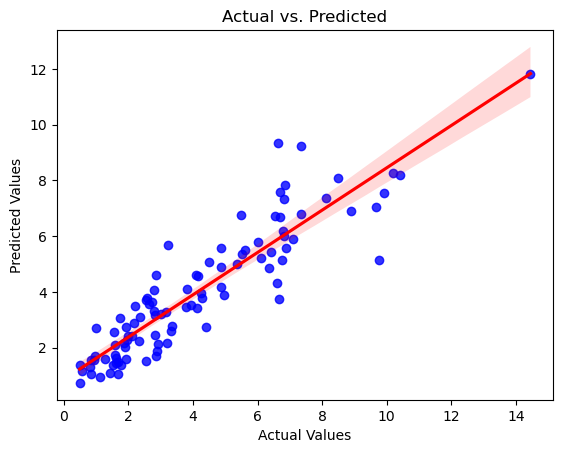

In [84]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Residual Plot
The residual plot shows more errors in predicting the clutch score are between 1 and -1. However, there are a few points outside of this range, which may be considered as outliers.

<Axes: xlabel='clutch_score'>

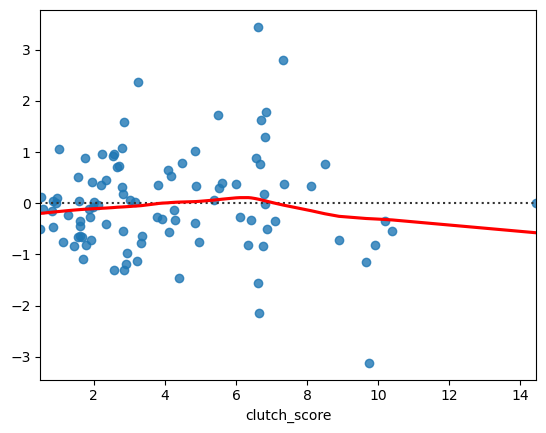

In [86]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))

### Cook's Distance
Cook's distance enables us to evaluate influential points in the model. Influential points are data points that significantly change the fit of the model if removed.

Cook's distance combines residuals (difference between the observed and predicted values) and leverage (how far away a data point is from the average of the predictor values) to determine the effect of the fit and predictions of a model when a data point is removed. A Cook's distance larger than the threshold (4 / n, with n being the number of observations) suggests that removing a particular data point would significantly change the model.

As shown below, the model tends to underestimate the performance of several elite players (e.g., McDavid and Matthews) in clutch situations. These players' statistics may have created an artificial "ceiling" that limits the model’s ability to accurately predict their scoring ability in close and tied situations.

Conversely, the model overestimates the performance of other elite players (e.g., Kucherov and both Tkachuks), who do not perform as well in clutch scoring situations as their general statistics suggest.


There are 42 influential points.
Outliers based on Cook's Distance:
                Player  Actual  Predicted  Cook's Distance
335    Auston Matthews   14.45  12.426251         0.051260
254     David Pastrnak   13.14  10.795230         0.033939
284     Connor McDavid   12.80  11.796251         0.014856
321    Kirill Kaprizov   12.44   9.488354         0.018677
240     Leon Draisaitl   12.27   9.952654         0.030387
54      Max Pacioretty   11.25   8.882407         0.020114
400    Jason Robertson   10.92   7.833887         0.038024
340     Alex DeBrincat   10.49   9.125172         0.012514
220  Aleksander Barkov   10.41   8.480983         0.011643
362      Tage Thompson   10.31   7.601445         0.015547
171     Filip Forsberg   10.19   8.157733         0.015479
14       Alex Ovechkin   10.03  11.011815         0.023948
246        Jakub Vrana    9.95   5.559130         0.033016
60      Steven Stamkos    9.90   8.171681         0.009904
219   Nathan MacKinnon    9.81  11.841563      

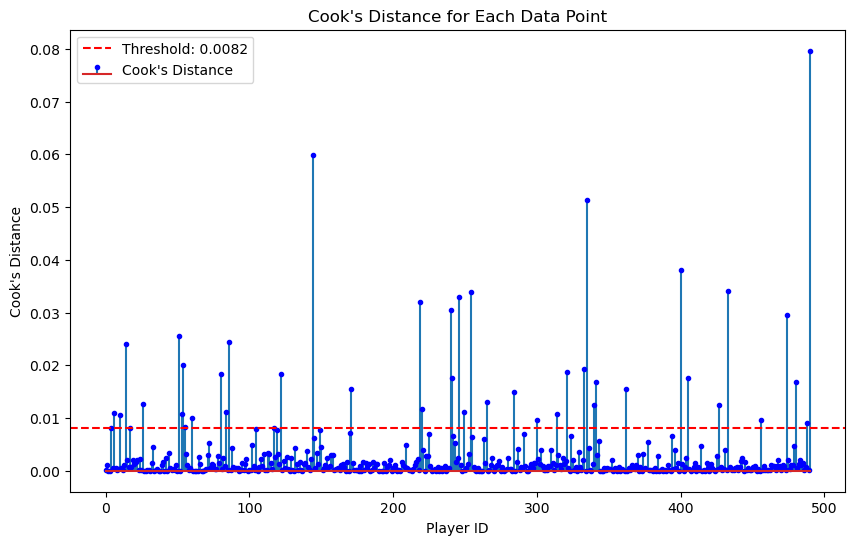

In [88]:
X_with_intercept = sm.add_constant(X_scaled)

ols_model = sm.OLS(y, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(results.index, cooks_d, markerfmt='b.', label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Player ID")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

### Evaluating the Distribution of the Data

The histogram and QQ plot show that the data has a right skew distribution, which may explain why the model has difficulties in predicting the clutch score of elite players on the right side of the tail.


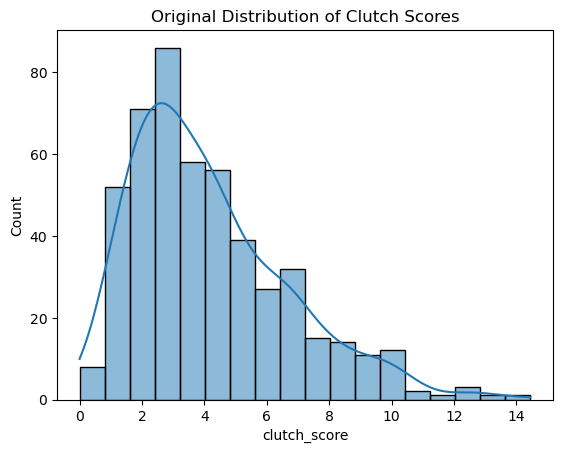

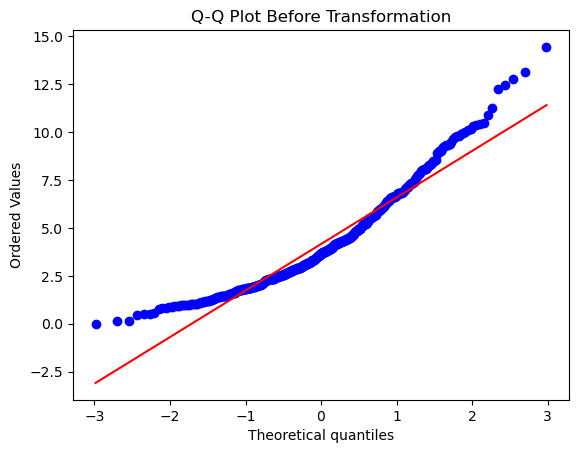

In [90]:
sns.histplot(y, kde=True)
plt.title("Original Distribution of Clutch Scores")
plt.show()
stats.probplot(y, dist="norm", plot=plt)
plt.title("Q-Q Plot Before Transformation")
plt.show()

### Transforming the Data to a Normal Distribution with Log

As shown below, a log transformation is used to reduce the skew of the data and create a normal distribution. This ensures the predictions are not affected by the influential points we identified in Cook's distance.


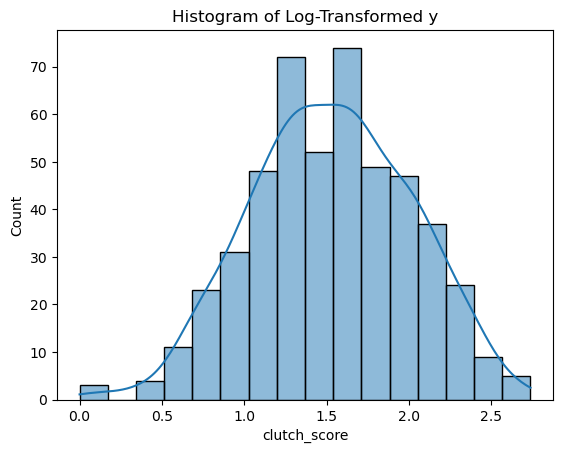

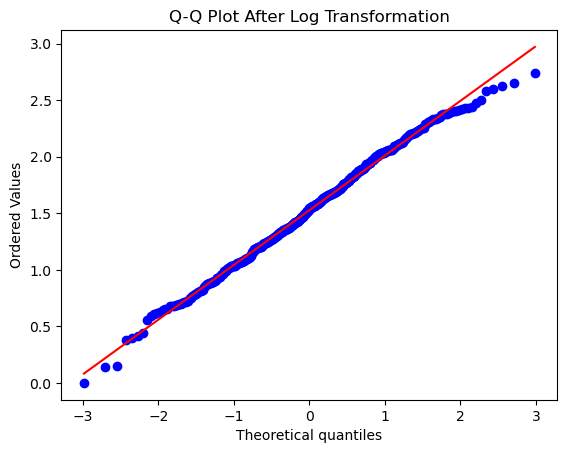

In [92]:
y_log = np.log(y + 1)  

sns.histplot(y_log, kde=True)
plt.title("Histogram of Log-Transformed y")
plt.show()

stats.probplot(y_log, dist="norm", plot=plt)
plt.title("Q-Q Plot After Log Transformation")
plt.show()

### Evaluating Metrics after the Log Transformation

After using a log transformation, it appears that the residuals have significantly decreased. However, it is important to remember the scale of the data has changed and we must look at the model's predictions of certain data points.

In [94]:
epsilon = np.abs(X_scaled.min()) + 1

X_shifted = X_scaled + epsilon

y_log = np.log(y + 1)

X_log = np.log(X_shifted)

train_x, test_x, train_y, test_y = train_test_split(
    X_log, 
    y_log, 
    test_size=0.2, 
    random_state=200
)

alphas_random = np.random.uniform(0.0001, 1000, 50)
ridge_cv_log = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv_log.fit(train_x, train_y)
y_pred = ridge_cv_log.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))


MSE:  0.053923547369900626
RMSE:  0.2322144426384815
MAE:  0.1194175944747955
R²:  0.7833414874775269
Adjusted R²:  0.7782235698588857


In [95]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(55))

All predictions and actual values:
                   Player    Actual  Predicted     Error
479       Quinton Byfield  0.722706   1.401295  0.678589
474            Jack Quinn  1.101940   1.665900  0.563960
389   Kristian Vesalainen  0.139762   0.684303  0.544542
480         Cole Perfetti  1.033184   1.549202  0.516017
17      Alexander Radulov  1.081805   1.597562  0.515757
410           David Kampf  0.896088   1.302434  0.406346
98         Calle Jarnkrok  1.888584   1.483142  0.405441
181         Teddy Blueger  0.924259   1.311532  0.387273
92    Nicolas Deslauriers  0.683097   1.068496  0.385399
375          Zack MacEwen  0.678034   1.049612  0.371578
139           Victor Rask  1.506297   1.136308  0.369990
421          Parker Kelly  0.657520   1.023137  0.365617
179      Jordan Martinook  1.169381   1.534789  0.365407
122     Brendan Gallagher  1.591274   1.949283  0.358009
483       Yegor Chinakhov  1.007958   1.357205  0.349247
32        Cal Clutterbuck  0.788457   1.137276  0.348

### Calculating Cook's Distance 

After we apply the log transformation and calculate Cook's distance, we can see that the elite players are no longer influential points. However, there are some players which the model still struggles with. The model undervalues some players (e.g. Vrana, Kuzmenko) who may perform better in close and tied situations than their metrics suggest. On the other hand, some players are overvalued and may have better metrics that may not fully reflect their clutch performance (e.g. Kucherov, Kane). While influential points are often viewed negatively, they can provide valuable insights. These points could help NHL coaching staff and management identify players who perform well in high-pressure situations, even if they aren’t considered elite based on traditional metrics.

Finally, some below-average players become influential because the log transformation tends to amplify the difference between smaller actual and predicted values.


There are 25 influential points.
Outliers based on Cook's Distance:
                   Player    Actual  Predicted  Cook's Distance
246           Jakub Vrana  2.393339   1.819142         0.014960
490       Andrei Kuzmenko  2.374906   1.798482         0.025378
144       Nikita Kucherov  2.032088   2.350460         0.011107
384  Jaret Anderson-Dolan  1.517323   1.014103         0.008591
126          Ryan Dzingel  1.465568   1.142429         0.008867
377            Mason Shaw  1.423108   1.076220         0.020823
318        Kevin Stenlund  1.408545   1.034701         0.011510
370      Michael Pezzetta  1.289233   0.857366         0.015394
269         Dakota Joshua  1.235471   0.925635         0.011101
183      Dominic Toninato  1.124930   0.821505         0.009921
474            Jack Quinn  1.101940   1.634659         0.030602
6            Ryan Getzlaf  1.088562   1.570778         0.016169
17      Alexander Radulov  1.081805   1.516370         0.014030
480         Cole Perfetti  1.033184 

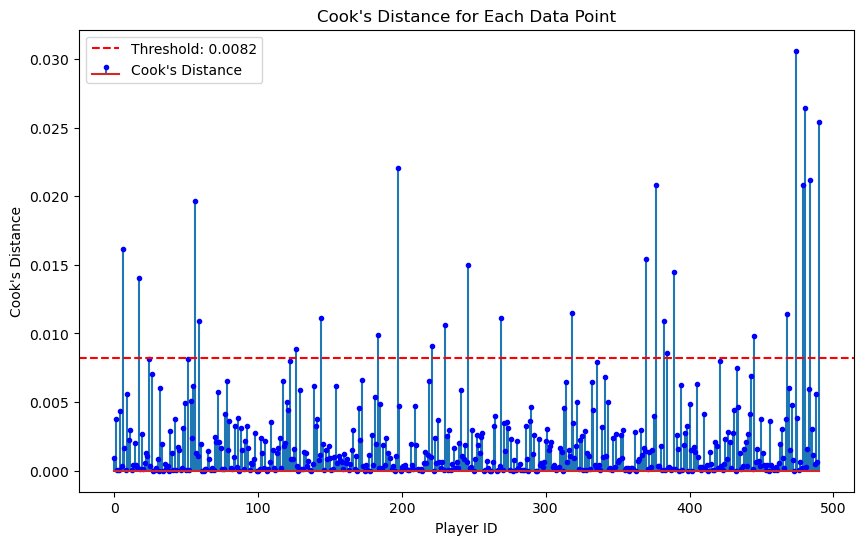

In [97]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_with_intercept)

outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(results.index, cooks_d, markerfmt='b.', label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Player ID")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

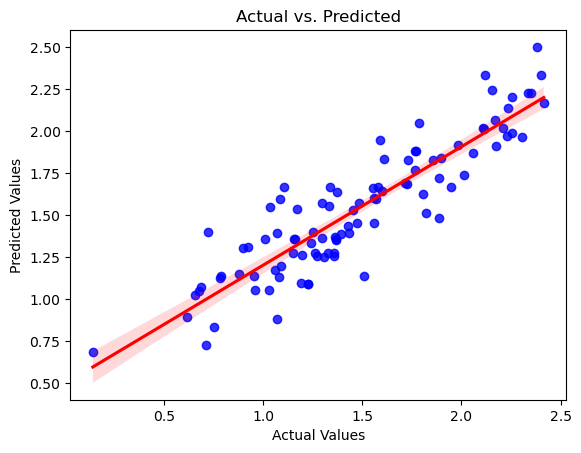

In [98]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Making Predicitons on Current Season Data

We save "ridge_cv_log" for reproductible results. We can then use it to make predictions on the current statistics of players (from 2023-2024 season to the current 2024-2025 season).

In [162]:
joblib.dump(ridge_cv_log, 'ridge_cv_model.pkl')
ridge_cv_log_loaded = joblib.load('ridge_cv_model.pkl')

In [164]:
all_seasons = []

for season in range(2023, 2025):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2023-2024
Successfully fetched data for season 2024-2025
     playerId      skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0     8470600          Ryan Suter            D          109       20        0   
1     8470604         Jeff Carter            C           72        4        0   
2     8470610         Zach Parise            L           30        5        0   
3     8470613         Brent Burns            D          108       39        0   
4     8470621         Corey Perry            R           80       13        0   
..        ...                 ...          ...          ...      ...      ...   
972   8484779       Jett Luchanko            C            4        0        0   
973   8484801   Macklin Celebrini            C           17        7        1   
974   8484911         Collin Graf            R            7        2        0   
975   8484958     Maxim Tsyplakov            R           27       10        0   
976   8485105  

In [166]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 35)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df.rename(columns={'timeOnIcePerGame': 'time_on_ice_per_game'}, inplace=True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [168]:
start_season = "20232024"
end_season = "20242025"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [170]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [171]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rebounds Created', 'iCF']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 35]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)
merged_natural_stat.rename(columns={'Rebounds Created': 'rebounds_created'}, inplace=True)

In [172]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Alexander Nylander", "Jacob Lucchini", ] 
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Alex Nylander", "Jake Lucchini"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [173]:
merged_clutch_goals_prediction = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [174]:
merged_clutch_goals_prediction.drop(columns = 'GP', axis = 1, inplace = True)

In [175]:
columns = ['ot_goals', 'regulation_game_winning', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'rebounds_created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals_prediction[per_game_string] = merged_clutch_goals_prediction[column] / merged_clutch_goals_prediction['gamesPlayed']

In [176]:
merged_clutch_goals_prediction['clutch_score'] = (
    0.35 * merged_clutch_goals_prediction['goals_when_tied_per_game'] + 
    0.35 * merged_clutch_goals_prediction['goals_down_by_one_per_game'] + 
    0.10 * merged_clutch_goals_prediction['goals_up_by_one_per_game'] + 
    0.20 * merged_clutch_goals_prediction['ot_goals_per_game']
)

In [177]:
merged_clutch_goals_prediction['clutch_score'] *= 100
merged_clutch_goals_prediction['clutch_score_rank']  = merged_clutch_goals_prediction['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals_prediction['clutch_score'] = merged_clutch_goals_prediction['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals_prediction[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
255,Auston Matthews,17.32,1.0
173,Sam Reinhart,14.63,2.0
174,Leon Draisaitl,13.83,3.0
244,Kirill Kaprizov,13.28,4.0
239,Artemi Panarin,12.26,5.0
194,Brayden Point,11.88,6.0
187,David Pastrnak,11.73,7.0
180,Dylan Larkin,11.28,8.0
209,Kyle Connor,10.82,9.0
160,Valeri Nichushkin,10.31,10.0


In [178]:
merged_clutch_goals_prediction.fillna(0, inplace = True)
null_rows = merged_clutch_goals_prediction[merged_clutch_goals_prediction.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, assists, ot_goals, game_winning_goals, time_on_ice_per_game, regulation_game_winning, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, rebounds_created, iCF, ot_goals_per_game, regulation_game_winning_per_game, assists_per_game, goals_up_by_one_per_game, goals_down_by_one_per_game, goals_when_tied_per_game, shots_per_game, ixG_per_game, iFF_per_game, iSCF_per_game, iHDCF_per_game, iCF_per_game, rebounds_created_per_game, clutch_score, clutch_score_rank]
Index: []

[0 rows x 35 columns]


In [179]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals_prediction[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals_prediction[y_var]

In [180]:
X_scaled = StandardScaler().fit_transform(X_adjusted)
X_scaled = np.nan_to_num(X_scaled, nan=0)

epsilon = np.abs(X_scaled.min()) + 1

X_shifted = X_scaled + epsilon

y_log = np.log(y + 1)

X_log = np.log(X_shifted)

y_pred = ridge_cv_log_loaded.predict(X_log)

In [181]:
merged_clutch_goals_prediction

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,time_on_ice_per_game,regulation_game_winning,goals_up_by_one,...,goals_when_tied_per_game,shots_per_game,ixG_per_game,iFF_per_game,iSCF_per_game,iHDCF_per_game,iCF_per_game,rebounds_created_per_game,clutch_score,clutch_score_rank
255,8479318,Auston Matthews,C,97,46,3,8,1249.52505,5,15.0,...,0.237113,4.525773,0.561959,6.618557,5.381443,2.350515,8.505155,0.835052,17.32,1.0
173,8477933,Sam Reinhart,C,109,55,3,12,1223.25315,9,17.0,...,0.266055,2.798165,0.451468,4.293578,3.568807,1.844037,5.366972,0.550459,14.63,2.0
174,8477934,Leon Draisaitl,C,107,80,5,12,1259.96030,7,5.0,...,0.214953,2.700935,0.345327,3.990654,2.915888,1.065421,5.186916,0.429907,13.83,3.0
244,8478864,Kirill Kaprizov,L,99,73,3,12,1320.28580,9,10.0,...,0.222222,3.626263,0.488990,5.383838,4.161616,1.737374,7.717172,0.777778,13.28,4.0
239,8478550,Artemi Panarin,L,106,87,1,6,1190.81705,5,9.0,...,0.188679,3.632075,0.355849,5.320755,3.424528,0.754717,7.962264,0.556604,12.26,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,8475235,Nicolas Deslauriers,L,67,4,0,0,426.91185,0,0.0,...,0.000000,0.791045,0.093284,1.283582,0.761194,0.432836,1.641791,0.089552,0.00,435.0
203,8478104,Sammy Blais,L,53,6,0,0,581.35840,0,0.0,...,0.000000,0.622642,0.069057,0.905660,0.773585,0.433962,1.264151,0.113208,0.00,435.0
343,8480870,Bo Groulx,C,45,2,0,0,731.31110,0,0.0,...,0.000000,0.711111,0.081333,1.200000,0.911111,0.422222,1.822222,0.133333,0.00,435.0
280,8479543,Michael Pezzetta,L,64,9,0,1,509.54365,1,0.0,...,0.000000,0.671875,0.060469,1.031250,0.640625,0.281250,1.578125,0.109375,0.00,435.0


In [182]:
merged_clutch_goals_prediction['predicted_clutch_score'] = y_pred 
merged_clutch_goals_prediction['log'] = np.log(merged_clutch_goals_prediction['clutch_score'] + 1) 

In [183]:
merged_clutch_goals_prediction['log_adjusted'] = np.log(merged_clutch_goals_prediction['clutch_score'] + 1) * 10
merged_clutch_goals_prediction['predicted_clutch_score_adjusted'] = y_pred * 10
merged_clutch_goals_prediction = merged_clutch_goals_prediction.sort_values(by='predicted_clutch_score_adjusted', ascending = False)
merged_clutch_goals_prediction['log_adjusted'] = merged_clutch_goals_prediction['log_adjusted'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction['predicted_clutch_score_adjusted'] = merged_clutch_goals_prediction['predicted_clutch_score_adjusted'].apply(lambda x: round(x, 2))

### Making the Results Interpretable

To make the results more interpretable, I have made the following changes:
- Player's predicted and clutch score multiplied by 10
- A tier for the player based on how far they are from the mean for clutch score
- A percentage difference between their actual and predicted values
- A classification for the percentage diff

The results will be saved in an Excel file: "Player Clutch Statisticserence


In [206]:
def create_clutch_rankings(df):

    def assign_tier(z_score):
        if z_score >= 2:
            return 'Franchise'
        elif z_score >= 1.5:
            return 'Elite'
        elif z_score >= 1:
            return 'Above Average'
        elif z_score > -1:
            return 'Below Average'
        else:
            return 'Limited Clutch Impact'

    rankings = df.copy()
    mean_score = rankings['log_adjusted'].mean()
    std_score = rankings['log_adjusted'].std()
    rankings['standard_deviations'] = (rankings['log_adjusted'] - mean_score) / std_score
    
    rankings['tier'] = rankings['standard_deviations'].apply(assign_tier)
    
    rankings['vs_predicted'] = ((rankings['log_adjusted'] - rankings['predicted_clutch_score_adjusted']) / rankings['predicted_clutch_score_adjusted'] * 100).round(2)
    rankings['vs_predicted'] = rankings['vs_predicted'].apply(lambda x: f"+{x}%" if x > 0 else f"{x}%")
            
    def get_prediction_reliability(diff):
        diff_num = float(diff.rstrip('%'))
        if diff_num >= 0:
            if  diff_num <= 10:
                return 'Slightly Overperforming'
            elif diff_num <= 20:
                return 'Overperforming'   
            else:
                return 'Heavily Overperforming'
        elif diff_num <= 0:
            if  diff_num >= -10:
                return 'Slightly Underperforming'
            elif diff_num >= -20:
                return 'Underperforming'   
            else:
                return 'Heavily Underperforming'   

    
    rankings['Prediction Reliability'] = rankings['vs_predicted'].apply(get_prediction_reliability)
    
    output = rankings[[
        'Player',
        'predicted_clutch_score_adjusted',
        'log_adjusted',
        'tier',
        'vs_predicted',
        'Prediction Reliability'
    ]].sort_values('log_adjusted', ascending=False)
    
    output = output.reset_index(drop=True)
    output.index = output.index + 1
    
    output.columns = ['Player', 'Predicted Clutch Score', 'Actual Clutch Score', 'Tier', 'Predicted VS Actual', 'Reliability']

    output.to_excel("Player Clutch Statistics.xlsx")
    
    return output.to_dict(orient='records')

### Cook's Distance Observations

The model shows the same patterns as before - it undervalues and overvalues some players. A few differences are also amplified by the log transformation.

There are 29 influential points.
Outliers based on Cook's Distance:
                  Player    Actual  Predicted  Cook's Distance
154     Nathan MacKinnon  2.337952   2.735336         0.012971
181         Sonny Milano  2.069391   1.085673         0.043843
137        Jake Guentzel  1.903599   2.524081         0.020251
84      Vincent Trocheck  1.867176   2.307046         0.009259
282      Michael Carcone  1.837370   1.128250         0.017892
252      Matthew Tkachuk  1.816452   2.161900         0.009428
298       Jesper Boqvist  1.646734   1.005989         0.011974
378          Shane Pinto  1.510722   2.085218         0.009363
93   Ryan Nugent-Hopkins  1.403643   2.015862         0.009303
290       Vinni Lettieri  1.396245   0.838358         0.013618
82       Johnny Gaudreau  1.278152   1.796525         0.011241
122        Chris Tierney  1.105257   0.636904         0.009413
66         Austin Watson  1.098612   0.480701         0.020540
60      Evgeny Kuznetsov  0.951658   1.489554     

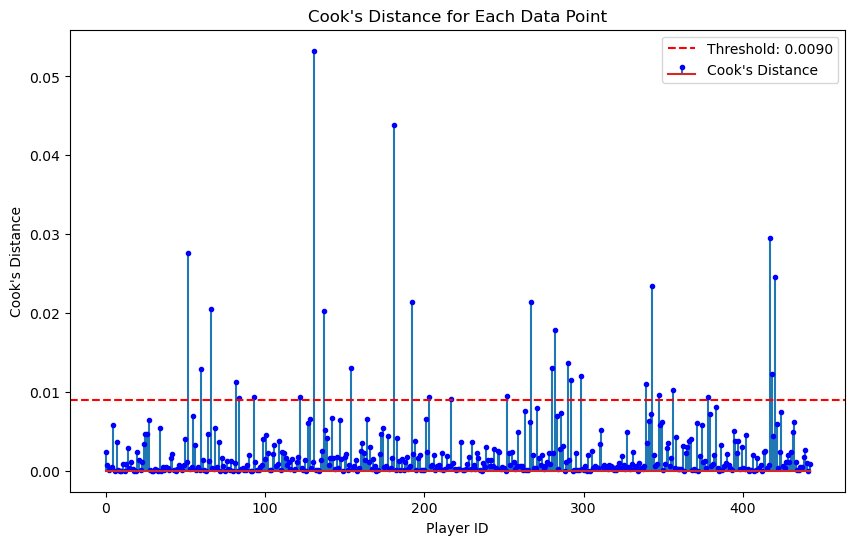

In [209]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)

outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals_prediction.loc[y.index, 'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(results.index, cooks_d, markerfmt='b.', label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Player ID")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

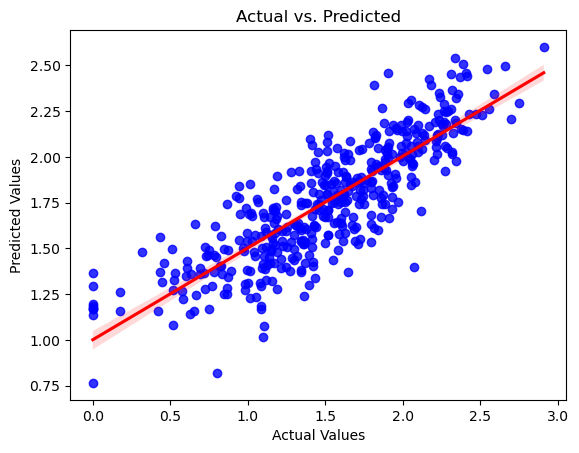

In [210]:
sns.regplot(data=merged_clutch_goals_prediction, x=merged_clutch_goals_prediction['log'], y=merged_clutch_goals_prediction['predicted_clutch_score'], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Concluding Thoughts
Through this project, I hope that I have built a well-tuned regression model that is able to perform well in predicting the clutch score of NHL players. Although Cook's distance did identify some influential points in the final model, these points may be useful in determining overvalued and undervalued players.

I hope to and connect the model to a PowerBI dashboard to provide real-time updates on the clutch performance of players.